# Decision Tree Analysis

In this Notebook file, I built a function to calculate entropy of a dataframe w.r.to a target column and use it to start building a decision tree for the employees dataset. 
1. You will see the successful identification of the features that provides MAX INFORMATION GAIN, be them continuous or discrete. 
2. I wrote two functions for these two types of features to identify the Info Gain and in the case of continuous variables the value that splits the variable to give the best information gain.
3. Later on we build the tree manually using these two till depth 2 as a demonstration of successful application of fundamental concepts.

Finally, we will use inbuilt features of scikit library to build the whole tree, whilst proving our earlier identifications and completing the tree.

Additionally, we have an orange file that contains the same decision tree that serves as an additional validation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("Why are employees leaving.csv")  #Loading file into my Notebook
df.head()

,ID,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Division,salary
0,1,0.38,0.53,2,157,3,0,1,0,sales,low
1,2,0.80,0.86,5,262,6,0,1,0,sales,medium
2,3,0.11,0.88,7,272,4,0,1,0,sales,medium
3,4,0.72,0.87,5,223,5,0,1,0,sales,low
4,5,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
df['Division'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

### Calculating Entropy for a dataset when given a target column ###

In [3]:
# Calculate entropy based on the 'left' column
import math

def calculate_entropy(data, target_column):
    """
    Calculate entropy for a given target column
    Entropy = -Σ(p * log2(p)) where p is the probability of each class
    """
    # Get value counts and probabilities
    value_counts = data[target_column].value_counts()
    total_samples = len(data)
    
    entropy = 0
    # print(f"Distribution of '{target_column}' column:")
    # print(f"Total samples: {total_samples}")
    
    for value, count in value_counts.items():
        probability = count / total_samples
        if probability > 0:  # Avoid log(0)
            entropy -= probability * math.log2(probability)
        # print(f"  {target_column}={value}: {count} samples ({probability:.4f} probability)")
    
    return entropy

# Calculate entropy for the 'left' column
# entropy_left = calculate_entropy(df, 'left')
# print(f"\n Baseline Entropy of the dataset based on 'left' column: {entropy_left:.4f}")



### Information Gains for Discrete and Continuous Features ###

In [4]:
# INFORMATION GAIN CALCULATION FOR DISCRETE FEATURES

def calculate_information_gain_discrete(data, feature_column, target_column):
    # Step 1: Calculate original entropy (baseline entropy of target variable)
    # print(f"=== INFORMATION GAIN ANALYSIS FOR '{feature_column.upper()}' COLUMN ===\n")
    
    original_entropy = calculate_entropy(data, target_column)
    # print(f"\nBASELINE ENTROPY of '{target_column}' column: {original_entropy:.4f}")
    
    # Step 2: Get unique values in the feature column to split on
    unique_values = data[feature_column].unique()
    # print(f"\nUNIQUE VALUES in '{feature_column}' column: {unique_values}")
    
    total_samples = len(data)
    weighted_entropy = 0
    
    for value in unique_values:
        # Create subset of data for this feature value
        subset = data[data[feature_column] == value]
        subset_size = len(subset)
        
        # Calculate entropy for this subset
        subset_entropy = calculate_entropy(subset, target_column)
        
        # Calculate weight (proportion of total data this subset represents)
        weight = subset_size / total_samples
        
        # Add to weighted entropy calculation
        weighted_entropy += weight * subset_entropy
    
    # Step 4: Calculate Information Gain
    information_gain = original_entropy - weighted_entropy
   
    # print(f"\nInformation Gain is {information_gain:.4f} for {feature_column} column")
    return {'information_gain': round(information_gain, 4),
            'weighted_entropy': round(weighted_entropy, 4), 
            'original_entropy': round(original_entropy, 4),
            'feature_column': feature_column,
            'split': None}

In [5]:
# Information Gain for Continuous Features

def calculate_information_gain_continuous(data, feature_column, target_column):
    # Check if data is empty
    if len(data) == 0:
        print(f"Warning: No data available for feature '{feature_column}'")
        return {'information_gain': 0, 
                'weighted_entropy': 0, 
                'original_entropy': 0, 
                'feature_column': feature_column, 
                'split': None}
    
    # Sort the unique values of the feature column
    original_entropy = calculate_entropy(data, target_column)
    # print(f"\nBASELINE ENTROPY of '{target_column}' column: {original_entropy:.4f}")
    total_samples = len(data)

    # print(f"{feature_column}")
    
    sorted_values = np.sort(data[feature_column].unique())
    # print("Sorted values:", sorted_values, len(sorted_values))
    
    # Check if there are no unique values or only one unique value
    if len(sorted_values) < 1:
        print(f"Warning: Cannot create splits for feature '{feature_column}' - insufficient unique values")
        return {'information_gain': 0, 
                'weighted_entropy': original_entropy, 
                'original_entropy': round(original_entropy, 4), 
                'feature_column': feature_column, 
                'split': sorted_values[0] if len(sorted_values) == 1 else None}


    def create_feature_splits(sorted_values):
        modified_sortedValues = []
        for i in range(len(sorted_values) - 1):
            modified_sortedValues.append((sorted_values[i] + sorted_values[i+1])/2)
        return modified_sortedValues
    
    feature_splits = create_feature_splits(sorted_values)
    # print("Feature splits:", feature_splits, len(feature_splits))
    
    # Check if feature_splits is empty
    if len(feature_splits) == 0:
        print(f"Warning: No splits possible for feature '{feature_column}'")
        return {'information_gain': 0, 
                'weighted_entropy': original_entropy, 
                'original_entropy': round(original_entropy, 4), 
                'feature_column': feature_column, 
                'split': None}
    
    selected_split = feature_splits[0]
    max_information_gain = 0
    max_weighted_entropy = original_entropy
    
    # Calculate the information gain for each range
    for i,_ in enumerate(feature_splits):
        # print(f"Split {i}: {feature_splits[i], sorted_values[i], sorted_values[i+1]}")
        subset1 = data[data[feature_column] >= feature_splits[i]]
        subset1_size = len(subset1)
        subset1_entropy = calculate_entropy(subset1, target_column)
        weight1 = subset1_size / total_samples
        # print("Subset:", len(subset))
        
        subset2 = data[data[feature_column] < feature_splits[i]]
        subset2_size = len(subset2)
        subset2_entropy = calculate_entropy(subset2, target_column)
        weight2 = subset2_size / total_samples

        # print(f"Split {i}: {feature_splits[i]}")
        # print(f"Subset1: {subset1_size} samples, entropy: {subset1_entropy:.4f}")
        # print(f"Subset2: {subset2_size} samples, entropy: {subset2_entropy:.4f}")

        weighted_entropy = weight1 * subset1_entropy + weight2 * subset2_entropy
        information_gain = original_entropy - weighted_entropy

        if information_gain > max_information_gain:
            max_information_gain = information_gain
            selected_split = feature_splits[i]
            max_weighted_entropy = weighted_entropy
        # print("Subset1:", len(subset1))
    # print(f"\nMax information gain is {max_information_gain:.4f} for {feature_column} column and split is {selected_split}, {max_weighted_entropy}")
    return {'information_gain': round(max_information_gain, 4), 
            'weighted_entropy': round(max_weighted_entropy, 4), 
            'original_entropy': round(original_entropy, 4), 
            'feature_column': feature_column, 
            'split': round(selected_split, 3) if selected_split is not None else None}

# calculate_information_gain_continuous(df, 'satisfaction_level', 'left')


### Using the above two functions to calculate max info gain across the whole dataset ###

In [6]:
# df.describe()
def calculate_max_information_gain(df, df_name):
    satisfaction= calculate_information_gain_continuous(df, 'satisfaction_level', 'left')
    last_evaluation= calculate_information_gain_continuous(df, 'last_evaluation', 'left')
    salary= calculate_information_gain_discrete(df, 'salary', 'left')
    division= calculate_information_gain_discrete(df, 'Division', 'left')
    average_montly_hours= calculate_information_gain_continuous(df, 'average_montly_hours', 'left')
    time_spend_company= calculate_information_gain_continuous(df, 'time_spend_company', 'left')
    number_project= calculate_information_gain_continuous(df, 'number_project', 'left')
    work_accident= calculate_information_gain_discrete(df, 'Work_accident', 'left')
    promotion_last_5years= calculate_information_gain_discrete(df, 'promotion_last_5years', 'left')
    
    features = [satisfaction, last_evaluation, salary, division, average_montly_hours, time_spend_company, number_project, work_accident, promotion_last_5years]

    information_gains = [feature['information_gain'] for feature in features]
    max_information_gain = max(information_gains)
    # print(f"\nOptimal Feature information for {df_name} \n {features[information_gains.index(max_information_gain)]}")
    return features[information_gains.index(max_information_gain)]

## Application of the above on the Dataset ##

#### Step 1 - Apply Function on the Root Node (Depth 0->1) ####

In [7]:
optimum_feature = calculate_max_information_gain(df, "Root Node")
print(f"\nOptimum Feature for Root Node is {optimum_feature}")


Optimum Feature for Root Node is {'information_gain': 0.1926, 'weighted_entropy': 0.5993, 'original_entropy': 0.7918, 'feature_column': 'satisfaction_level', 'split': 0.465}


#### STEP 2 - Split Root Node and apply the function on each leaf (Depth 1->2) ####
We split the data of root node into two based on the suggested split in the above output i.e Satisfaction level and 0.465
1. Node 1 for Sat. Level <= 0.465
2. NODE 2 for Sat. Level > 0.465

In [8]:
#NODE 1 => Sat. Level <= 0.465
df1 = df[df['satisfaction_level'] <= 0.465]
optimum_feature_1 = calculate_max_information_gain(df1, "NODE 1")

#NODE 2 => Sat. Level > 0.465
df2 = df[df['satisfaction_level'] > 0.465]
optimum_feature_2 = calculate_max_information_gain(df2, "NODE 2")

print (f"\n Optimum Feature for NODE 1 is {optimum_feature_1}")
print (f"\n Optimum Feature for NODE 2 is {optimum_feature_2}")


 Optimum Feature for NODE 1 is {'information_gain': 0.1802, 'weighted_entropy': 0.7877, 'original_entropy': 0.9679, 'feature_column': 'satisfaction_level', 'split': 0.115}

 Optimum Feature for NODE 2 is {'information_gain': 0.185, 'weighted_entropy': 0.2716, 'original_entropy': 0.4567, 'feature_column': 'time_spend_company', 'split': 4.5}


#### STEP 3 - Split Nodes 1 and 2 to grow the tree further (Depth 2->3) ####
1. NODE 1 is going to be split into NODE 1.1 and NODE 1.2 based on satisfaction level at the value 0.115.
2. NODE 2 is going to be split into NODE 2.1 and NODE 2.2 based on time spent at the compnay at the value 4.5.


In [9]:
df11 = df1[df1['satisfaction_level'] <= 0.115]
optimum_feature_11 = calculate_max_information_gain(df11, "NODE 1.1")

df12 = df1[df1['satisfaction_level'] > 0.115]
optimum_feature_12 = calculate_max_information_gain(df12, "NODE 1.2")

print (f"\n Optimum Feature for NODE 1.1 is {optimum_feature_11}")
print (f"\n Optimum Feature for NODE 1.2 is {optimum_feature_12}")


#----------------------------------

df21 = df2[df2['time_spend_company'] <= 4.5]
optimum_feature_21 = calculate_max_information_gain(df21, "NODE 2.1")

df22 = df2[df2['time_spend_company'] > 4.5]
optimum_feature_22 = calculate_max_information_gain(df22, "NODE 2.2")

print (f"\n Optimum Feature for NODE 2.1 is {optimum_feature_21}")
print (f"\n Optimum Feature for NODE 2.2 is {optimum_feature_22}")



 Optimum Feature for NODE 1.1 is {'information_gain': 0, 'weighted_entropy': 0.0, 'original_entropy': 0.0, 'feature_column': 'satisfaction_level', 'split': 0.095}

 Optimum Feature for NODE 1.2 is {'information_gain': 0.5379, 'weighted_entropy': 0.4621, 'original_entropy': 1.0, 'feature_column': 'number_project', 'split': 2.5}

 Optimum Feature for NODE 2.1 is {'information_gain': 0.0063, 'weighted_entropy': 0.103, 'original_entropy': 0.1093, 'feature_column': 'average_montly_hours', 'split': 290.5}

 Optimum Feature for NODE 2.2 is {'information_gain': 0.3694, 'weighted_entropy': 0.626, 'original_entropy': 0.9954, 'feature_column': 'last_evaluation', 'split': 0.805}


### Stopping points and further steps ###
1. Node 1.1 is already completely sorted as the entropy is 0. No need to further prune it.
2. Node 2.1 has the max information gain to be just 0.0063, further building the tree from this node will not result in much value or information.

Stopping criteria have to be clearly defined and the tree can be grown till we run out of features or all terminal nodes hit the stopping criteria and we have a fully grown decision tree.

## Using Scikit Learn to build and grow the same decision tree ##

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   left                   14999 non-null  int64  
 8   promotion_last_5years  14999 non-null  int64  
 9   Division               14999 non-null  object 
 10  salary                 14999 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 1.3+ MB


This tells us that 2 out of the 10 features (excluding ID) of this dataset are categorical, which will have to be converted into numerical ones to be used for modeling. For this, we can make use of __LabelEncoder__ from the Scikit-Learn library.

***Given that the target variable 'left' is already encoded into 0 and 1, we don't have to do any processing for that column***

In [11]:
# Create a copy of the original dataframe
df_encoded = df.copy()

division_encoder = LabelEncoder()
salary_encoder = LabelEncoder()
df_encoded['Division'] = division_encoder.fit_transform(df_encoded['Division'])
df_encoded['salary'] = salary_encoder.fit_transform(df_encoded['salary'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   left                   14999 non-null  int64  
 8   promotion_last_5years  14999 non-null  int64  
 9   Division               14999 non-null  int64  
 10  salary                 14999 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 1.3 MB


In [12]:
# The Encodings are done as follows:

print (dict(zip(division_encoder.classes_, division_encoder.transform(division_encoder.classes_))))
print (dict(zip(salary_encoder.classes_, salary_encoder.transform(salary_encoder.classes_))))

{'IT': 0, 'RandD': 1, 'accounting': 2, 'hr': 3, 'management': 4, 'marketing': 5, 'product_mng': 6, 'sales': 7, 'support': 8, 'technical': 9}
{'high': 0, 'low': 1, 'medium': 2}


In [13]:
#NULL CHECK

df_encoded.isnull().sum()

ID                       0
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Division                 0
salary                   0
dtype: int64

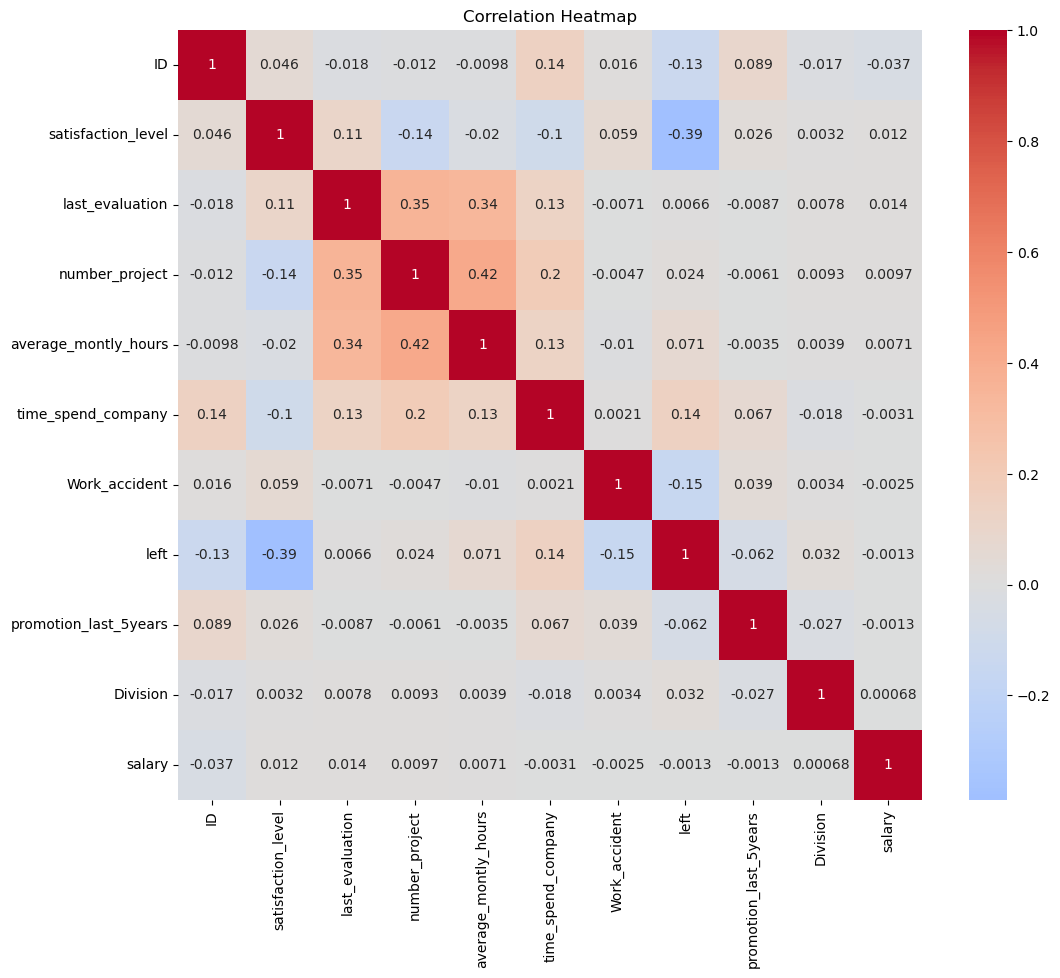

In [14]:
df_encoded.corr()
plt.figure(figsize=(12,10))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


#### It looks like there are no variables that are highly correlated to one another. No need to drop them for avoiding overfitting ####

Next we'll just look into the distribution with left column to see if there is any imbalance

In [15]:
left_category_counts = df_encoded['left'].value_counts()
left_category_counts



left
0    11428
1     3571
Name: count, dtype: int64

## Class imbalance is observed, but... ##

Decision Trees do not need balanced classes to work properly. The imbalance in classes in Decision Trees is automatically handled when calculating best feature to grow trees. This is because the metrics entropy and Gini Index are impurity indices that consider class distributions at each node.

**If Needed, Decision trees can adjust for this situation by penalising minority class mistakes more when developing trees by using class_weight=balanced**

## Next We will split the data into training and test data ##
1. Dropping left and ID columns from the Training set.
2. Printing Training set column info for comparison

In [16]:
X = df_encoded.drop(columns=['left', 'ID'])
y = df_encoded['left']

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X.info()}")
print(f"Test set size: {len(X_testset)}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   Division               14999 non-null  int64  
 8   salary                 14999 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 1.0 MB
Training set: None
Test set size: 3000


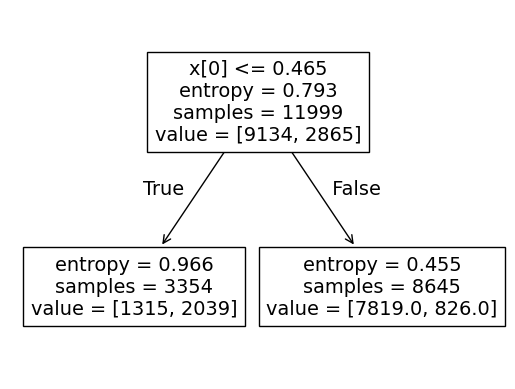

In [17]:
tree_depth_1 = DecisionTreeClassifier(max_depth=1, criterion='entropy')
tree_depth_1.fit(X_trainset, y_trainset)

plot_tree(tree_depth_1)
plt.show()

#### Verified X[0] is satisfaction level and the split is at 0.465 ####
1. Our custom built functions identified it correctly.

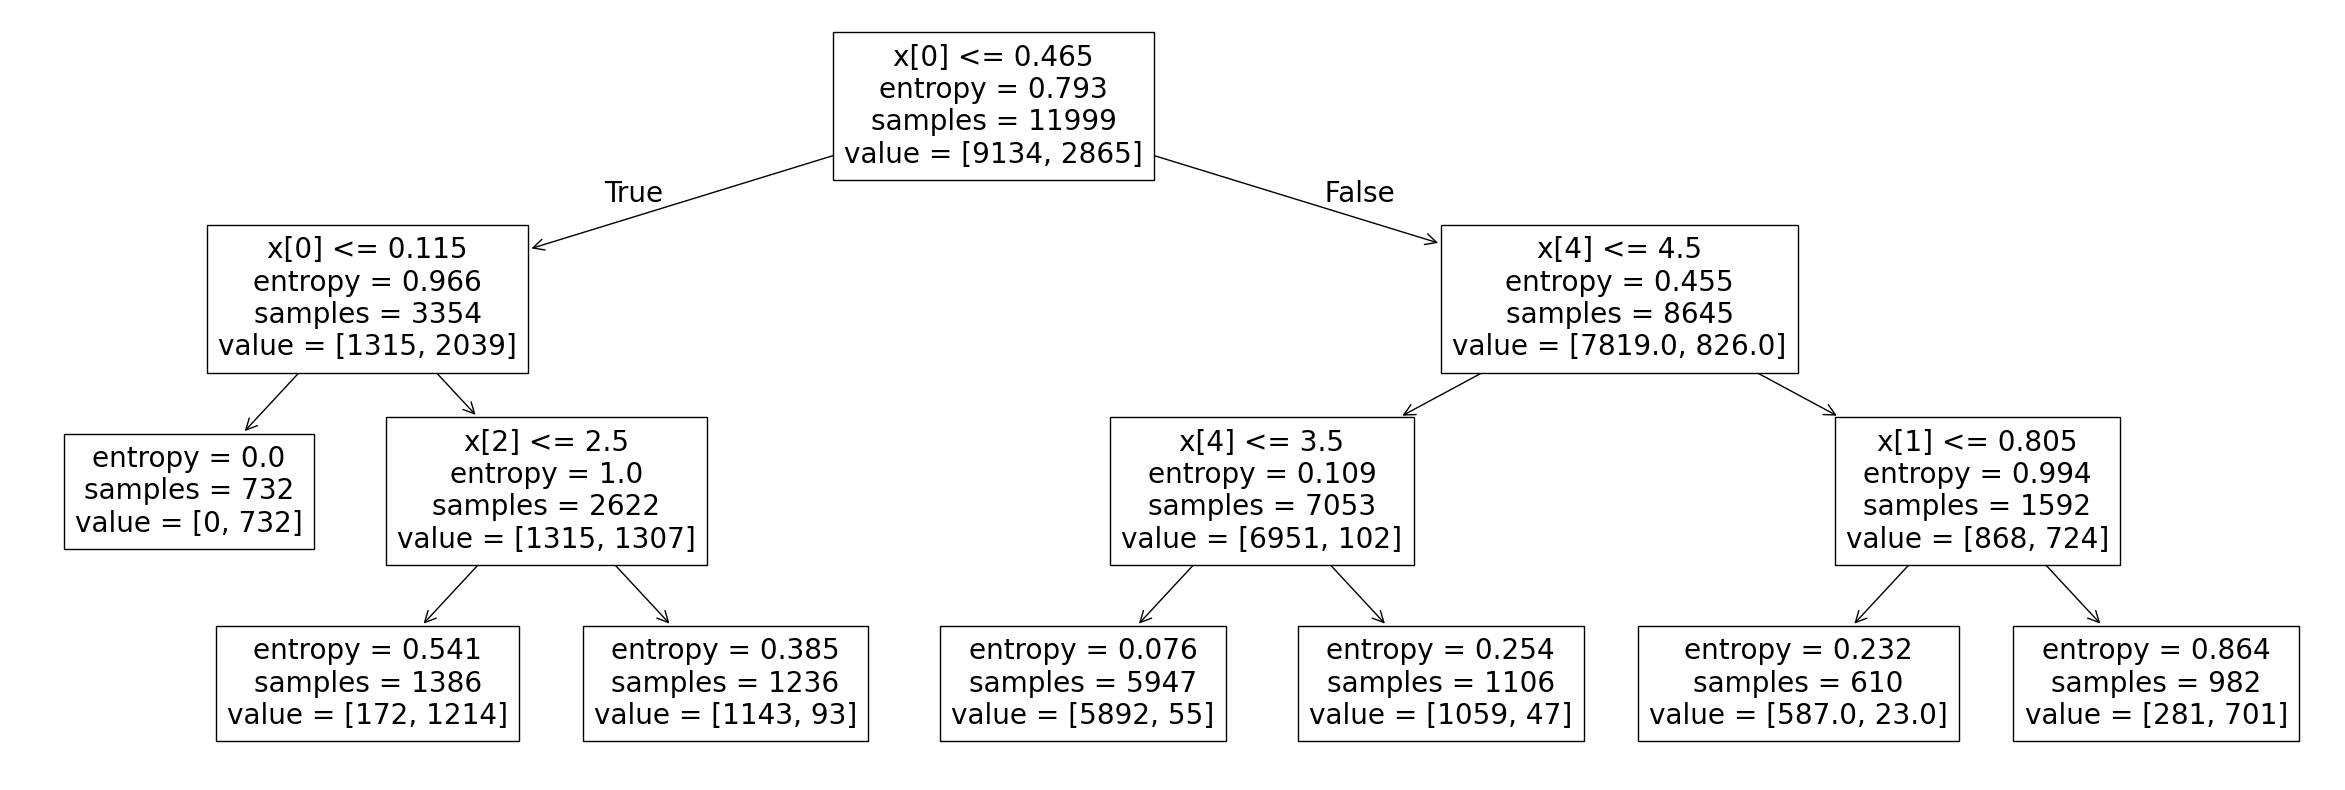

In [18]:
tree_depth_3 = DecisionTreeClassifier(max_depth=3, min_samples_split=10, min_samples_leaf=2, criterion='entropy', random_state=42)
tree_depth_3.fit(X_trainset, y_trainset)

plt.figure(figsize=(30,10))
plot_tree(tree_depth_3)
plt.show()

### This is also largely corresponding to what we have in our model. Node 2.1 is different but given the information gain is so low, a change in the sample can influence tree progression ###

Following are the function outputs we have from out custom built.

Optimum Feature for Root Node is {'information_gain': 0.1926, 'weighted_entropy': 0.5993, 'original_entropy': 0.7918, 'feature_column': 'satisfaction_level', 'split': 0.465}

Optimum Feature for NODE 1 is {'information_gain': 0.1802, 'weighted_entropy': 0.7877, 'original_entropy': 0.9679, 'feature_column': 'satisfaction_level', 'split': 0.115}

Optimum Feature for NODE 1.1 is {'information_gain': 0, 'weighted_entropy': 0.0, 'original_entropy': 0.0, 'feature_column': 'satisfaction_level', 'split': 0.095}

Optimum Feature for NODE 1.2 is {'information_gain': 0.5379, 'weighted_entropy': 0.4621, 'original_entropy': 1.0, 'feature_column': 'number_project', 'split': 2.5}


Optimum Feature for NODE 2 is {'information_gain': 0.185, 'weighted_entropy': 0.2716, 'original_entropy': 0.4567, 'feature_column': 'time_spend_company', 'split': 4.5}

Optimum Feature for NODE 2.1 is {'information_gain': 0.0063, 'weighted_entropy': 0.103, 'original_entropy': 0.1093, 'feature_column': 'average_montly_hours', 'split': 290.5}

Optimum Feature for NODE 2.2 is {'information_gain': 0.3694, 'weighted_entropy': 0.626, 'original_entropy': 0.9954, 'feature_column': 'last_evaluation', 'split': 0.805}

### Lets propagate the tree further ###

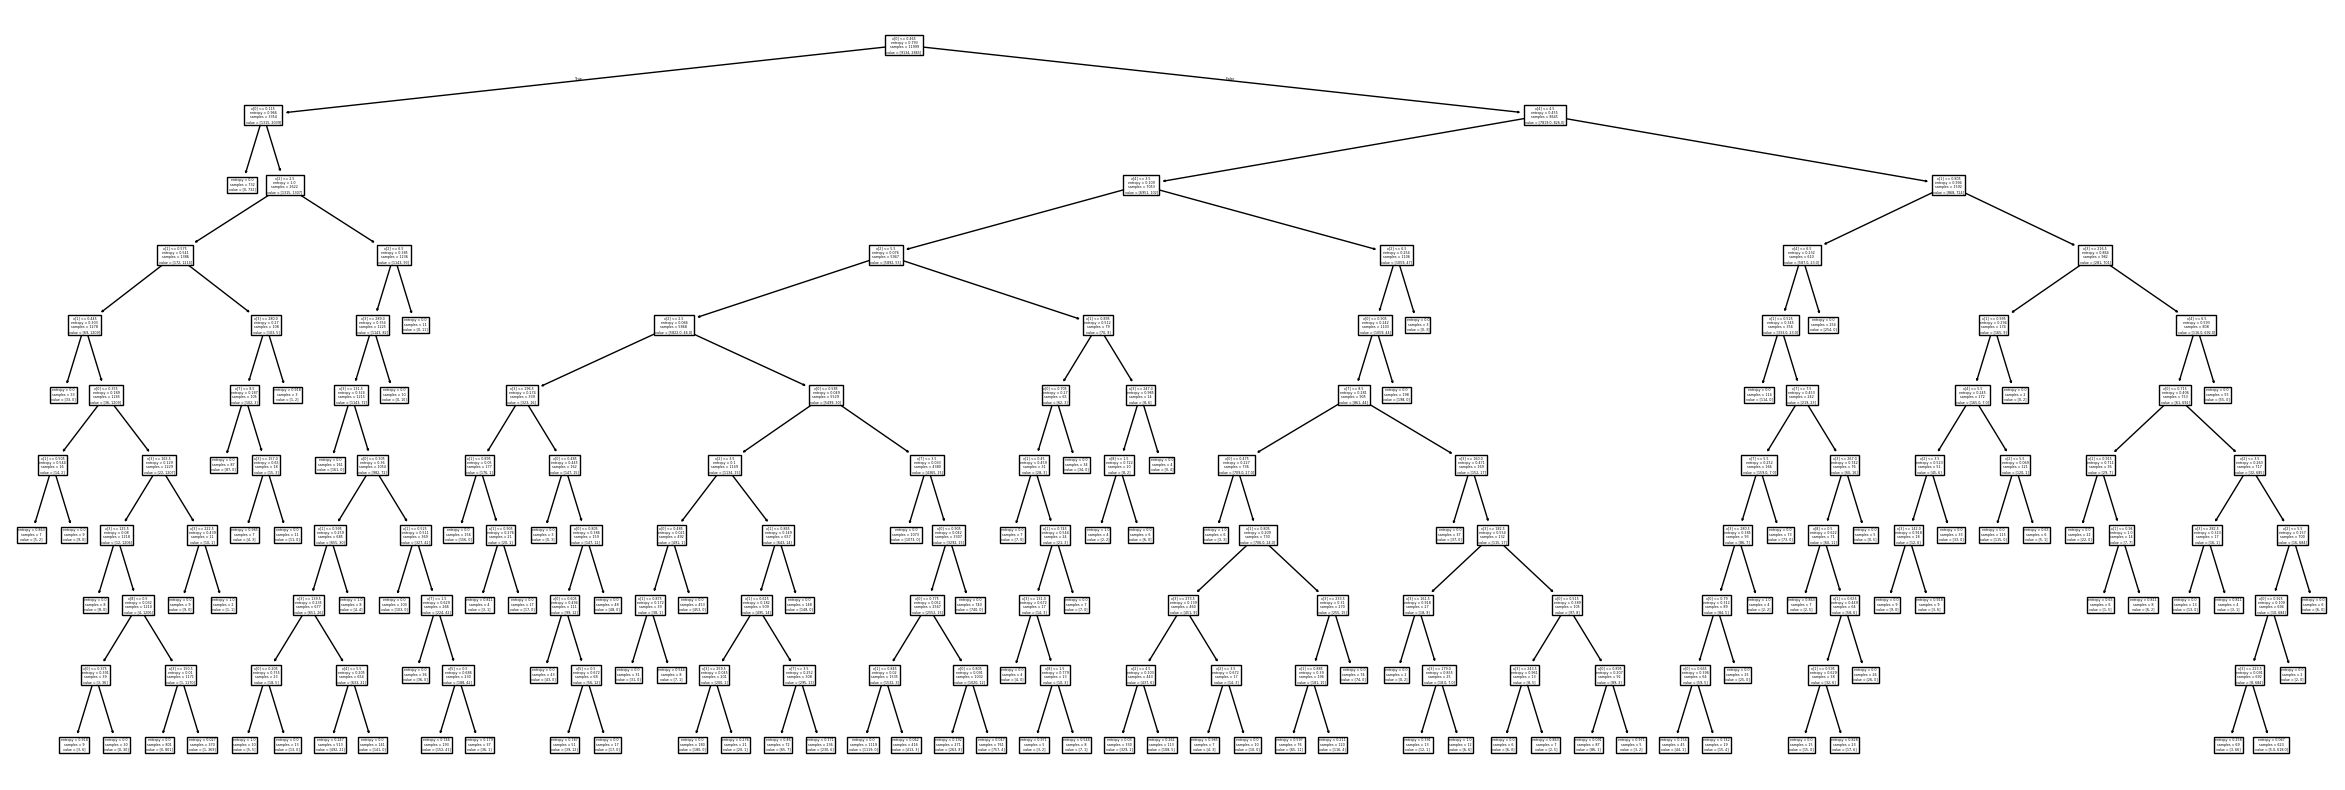

In [19]:
#Propagating the Tree further

tree_depth_10 = DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=2, criterion='entropy', random_state=42)
tree_depth_10.fit(X_trainset, y_trainset)

plt.figure(figsize=(30,10))
plot_tree(tree_depth_10)
plt.show()

#### Herein lies the challenge, The tree tries to classify further and further and only stops a node if its at 100%. Packages like Orange offer additional stoppage criteria where a node will stop branching if the majority class is greater than a certain % ####

Now Lets Predict the output on the test data and get the results

In [23]:
tree_prediction_1 = tree_depth_1.predict(X_testset)
tree_prediction_3 = tree_depth_3.predict(X_testset)
tree_prediction_10 = tree_depth_10.predict(X_testset)


print(f"Decision Tree with max depth 1 accuracy: {metrics.accuracy_score(y_testset, tree_prediction_1):.4f}")
print(f"Decision Tree with max depth 3 accuracy: {metrics.accuracy_score(y_testset, tree_prediction_3):.4f}")
print(f"Decision Tree with max depth 10 accuracy: {metrics.accuracy_score(y_testset, tree_prediction_10):.4f}")

Decision Tree with max depth 1 accuracy: 0.8163
Decision Tree with max depth 3 accuracy: 0.9457
Decision Tree with max depth 10 accuracy: 0.9753


### Depth increased from 3 to 10 but the accuracy is only increasing from 95% to 98% ###
These form some of the crucial inputs to limit the depth of a decision tree. For testing, we can check trees of depths 1-10 and plot the accuracies of them and check.

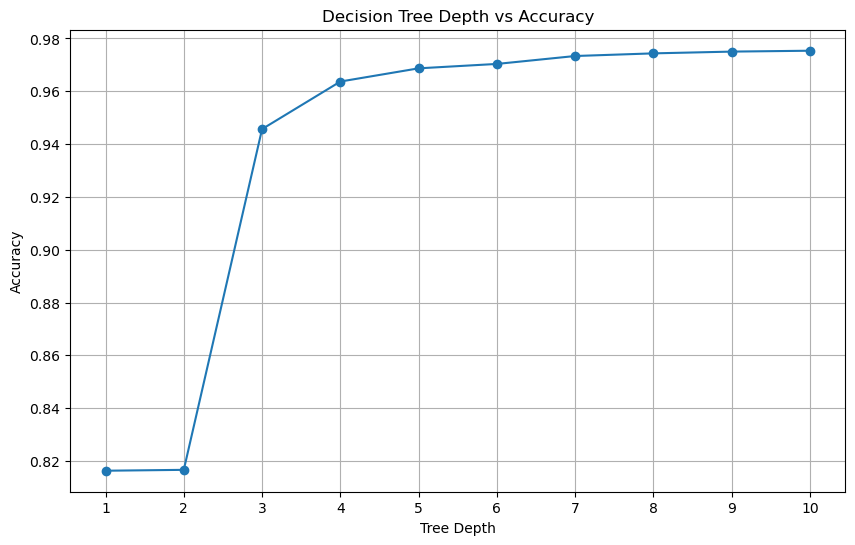

In [22]:
tree_depth_2 = DecisionTreeClassifier(max_depth=2, criterion='entropy', min_samples_split=10, min_samples_leaf=2, random_state=42)
tree_depth_2.fit(X_trainset, y_trainset)
tree_prediction_2= tree_depth_2.predict(X_testset)

tree_depth_4 = DecisionTreeClassifier(max_depth=4, criterion='entropy', min_samples_split=10, min_samples_leaf=2, random_state=42)
tree_depth_4.fit(X_trainset, y_trainset)
tree_prediction_4 = tree_depth_4.predict(X_testset)

tree_depth_5 = DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_split=10, min_samples_leaf=2, random_state=42)
tree_depth_5.fit(X_trainset, y_trainset)
tree_prediction_5 = tree_depth_5.predict(X_testset)

tree_depth_6 = DecisionTreeClassifier(max_depth=6, criterion='entropy', min_samples_split=10, min_samples_leaf=2, random_state=42)
tree_depth_6.fit(X_trainset, y_trainset)
tree_prediction_6 = tree_depth_6.predict(X_testset)

tree_depth_7 = DecisionTreeClassifier(max_depth=7, criterion='entropy', min_samples_split=10, min_samples_leaf=2, random_state=42)
tree_depth_7.fit(X_trainset, y_trainset)
tree_prediction_7 = tree_depth_7.predict(X_testset)

tree_depth_8 = DecisionTreeClassifier(max_depth=8, criterion='entropy', min_samples_split=10, min_samples_leaf=2, random_state=42)
tree_depth_8.fit(X_trainset, y_trainset)
tree_prediction_8 = tree_depth_8.predict(X_testset)

tree_depth_9 = DecisionTreeClassifier(max_depth=9, criterion='entropy', min_samples_split=10, min_samples_leaf=2, random_state=42)
tree_depth_9.fit(X_trainset, y_trainset)
tree_prediction_9 = tree_depth_9.predict(X_testset)


# Calculate accuracies for each depth
accuracies = []
depths = range(1,11)

for depth, prediction in zip(depths, [tree_prediction_1, tree_prediction_2, tree_prediction_3, 
                                    tree_prediction_4, tree_prediction_5, tree_prediction_6,
                                    tree_prediction_7, tree_prediction_8, tree_prediction_9, 
                                    tree_prediction_10]):
    accuracy = metrics.accuracy_score(y_testset, prediction)
    accuracies.append(accuracy)

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(depths, accuracies, marker='o', linestyle='-')
plt.title('Decision Tree Depth vs Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(depths)
plt.show()









## Observation ##
1. It is noted that accuracy gains post depth 4 are marginal, amounting to less than 1%.
2. A high jump from 2 to 3 depth is noticed and the accuracy reaches around 95% but stasy below it.
3. So the Ideal depth for the Decision Tree Model is around 3 or 4, depending on the accuracy requirements for the business and the computation constraints.

# Conclusion of the exercise #
1. We have built our own entropy calculator and built a tree which is then verified using the SCIKIT Library classifier.
2. We built a Decision Tree Model for the data, verified the accuracy at various depths in order to come to an understanding of an optimal depth.
